In [153]:
import os, sys, pickle, re
from os.path import join
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt
import numpy as np
import fasttext as ft
from tqdm import tqdm
tqdm.pandas()
sys.path.append('helpers/')
from tweetokenize import *
data_root= config.DATA_ROOT
import text_processing, preprocess_tweet_data, config
pd.options.display.max_colwidth = 300
NUM_USR_PROF_CLUSTER= '10 20 30 40 50 80 100'
ALGO_USR_PROF_CLUSTER='KMeans'

DATA_ROOT = config.DATA_ROOT
TWEET_USER_DF = join(DATA_ROOT, 'users-all.pkl') #containing profile info for all users
TWEET_USER_DF_EN = join(DATA_ROOT, 'users-en.pkl') #containing profile info for users with (detected) 'en' description
TWEET_USER_DF_EN_UNIQUE = join(DATA_ROOT, 'users-en-unique.pkl') #containing unique users with (detected) 'en' description
TWEET_USER_PROFILE_TEXT = join(DATA_ROOT, 'tweet-profile-text-en.txt') #file containing cleaned profile descriptions
CLEAN_TWEET_TEXT_EN = join(DATA_ROOT,'tweet-text-en.txt') #file containing cleaned tweet text
PROFILE_WORD_WEIGHTS = join(DATA_ROOT, 'weights.wgt') #store profile word weights
PROFILE_WORD_TFIDF = join(DATA_ROOT, 'tfidf') #store profile word tfidf scores
PROFILE_FT_MODEL = join(DATA_ROOT, 'ft-profile-sg') #fasttext model for profle desc, using skipgram to catch semantic relationships
TWEET_DF_FILE = join(DATA_ROOT, 'tweets-all.pkl')
EN_TWEET_DF_FILE = join(DATA_ROOT,'tweets-en.pkl') #dataframe with english tweets 
PRIV_TWEET_DF = join(DATA_ROOT,'tweets-priv.pkl') #dataframe containing sec/priv related tweets 
PRIV_TWEET_TEXT = join(DATA_ROOT,'tweet-text-priv.txt') #file containing sec/priv tweet texts 
PRIV_TWEET_MODEL_PATH=join(DATA_ROOT, 'priv-tweet-models/') #directory for ft and cluster models for sec/priv related tweets
PRIV_FT_MODEL  = join(PRIV_TWEET_MODEL_PATH, 'ft-priv-tweet-sg') #ft model name for sec/priv related tweets
USR_CLUSTER_DIR = join(DATA_ROOT, 'profile-cluster-models') #directory to save profile cluster models and outputs
USR_CLUSTER_MOD = join(USR_CLUSTER_DIR, 'model-KMeans-{}-0.model'.format(NUM_USR_PROF_CLUSTER))
TWEET_TOPIC_DIR = join(DATA_ROOT, 'tweet-topic') #directory to contain topic models and outputs for tweets
TWEET_SENTI_TRAIN_TEXT=join(DATA_ROOT,'tweet-senti-text.txt') #file containing text for training sentiment model


In [156]:
manuscriptColSize= 252
forLatex = True
latexDec = 4

plt.rc('text', usetex=False)
plt.rc('font', family='serif', serif='Times')
def get_fig_size(figWidthPt=manuscriptColSize, square=False):
    inches_per_pt = 1.0/72.27               # Convert pt to inches
    golden_mean = (math.sqrt(5)-1.0)/2.0         # Aesthetic ratio
    fig_width = figWidthPt*inches_per_pt  # width in inches
    fig_height = fig_width*golden_mean       # height in inches
    if square:
        return (fig_width, fig_width)
    return (fig_width,fig_height)

colors = ['teal','indianred','steelblue']
markers=['o','^','d','h','*','v','d','^','<']
linestyles=['-', '--', '-.', ':']
labelFont = 18
legendFont = 16
tickFont = 16

In [106]:
tags='#elearning, #edtech, #edreform, #blendchat,#mlearning, #ipadchat, #flipclass, #BYOD, #iPaded, #EdApps, #flipclass, #blendedlearning, #flatclass, #edreformtribe, #edreform, #eddata, #edadmin, #dropouts,#schoolreform, #homeschooling, #disted, #onlinelearning,#k12online, #globaled, #GsuiteEdu, #GoogleEdu, #Edtools, #Schoology, #schoolreform, \
#edadmin, #blendedlearning, #globaled, #iPaded, #ipadchat, #edreformtribe , #crisisteaching, #remotelearning, #remoteteaching, #openeducation, #mooc, \
#e-learning, #onlinelearning, #distancelearning, #ERL, #teachingtools,  #virtuallearning,  #EdTechX, #digitalequity, #mooc, #Udacity, #OnlineEd, #schoology, #LMS, #moodle, \
#googleedu, #MovingEduForward, #studentdataprivacy, #edapp, #digped, #edtechchat, #edtechinHE'
len(set(tags.split(',')))
print(list(set(tags.split(','))))

[' #crisisteaching', ' #edtech', ' #eddata', '#k12online', ' #teachingtools', ' #distancelearning', ' #Udacity', ' #edtechchat', ' #edadmin', ' #OnlineEd', '#mlearning', ' #googleedu', ' #edapp', ' #edtechinHE', ' #flipclass', ' #edreformtribe ', ' #LMS', ' #remoteteaching', ' #schoology', ' #onlinelearning', ' #remotelearning', ' #e-learning', '#elearning', ' #openeducation', ' #edreformtribe', ' #ipadchat', ' #studentdataprivacy', ' #BYOD', ' #blendchat', ' #globaled', ' #edreform', ' #schoolreform', ' #homeschooling', '  #EdTechX', ' #ERL', ' #iPaded', ' #GsuiteEdu', ' #digped', ' #GoogleEdu', ' #blendedlearning', ' #disted', ' #MovingEduForward', ' #Schoology', ' #digitalequity', ' #moodle', ' #Edtools', ' #mooc', ' #EdApps', '  #virtuallearning', '#schoolreform', ' #dropouts', ' #flatclass']


In [108]:
names= '@Schoology, @Schoolytics, @GoogleForEdu, @moodle, @MyPowerSchool, @CanvasLMS, @Educ_Technology, @EdTech_K12, @MerlynMind, @edXOnline, @DigitalPromise, @LearningAtScale, @edtechdigest, @edmodo, @ClassDojo, @Newsela, @quizizz,\
@blackboard, @edpuzzle, @PearDeck, @Flipgrid, @BookCreatorApp, @mergeedu, @BookCreatorApp, @Seesaw, @TeachFX, @udacity, @coursera, @udemy, @edXOnline, @MicrosoftEDU,\
@proctorio, @examity, @ProctortrackPro, @speedexam, @in_examonline, @MercerMettl,\
@Examus1, @ProctorU, @Verificient, @AIProctor, @ExamSoft, @conductexam, @ProctorExam, @PSIServicesLLC, @pearsonvue, @merittracsvc'

print(len(set(names.split(','))), list(set(names.split(','))))

45 [' @moodle', '@Schoology', ' @udacity', ' @PearDeck', ' @Schoolytics', ' @Verificient', ' @MercerMettl', ' @LearningAtScale', ' @ExamSoft', ' @examity', ' @AIProctor', ' @Educ_Technology', ' @edXOnline', ' @mergeedu', ' @quizizz', ' @speedexam', ' @EdTech_K12', ' @BookCreatorApp', ' @MicrosoftEDU', ' @ProctortrackPro', ' @edpuzzle', ' @ProctorU', ' @MerlynMind', ' @Newsela', ' @udemy', ' @edmodo', ' @Flipgrid', ' @PSIServicesLLC', ' @coursera', ' @pearsonvue', '@blackboard', ' @Seesaw', '@proctorio', ' @conductexam', ' @CanvasLMS', ' @merittracsvc', ' @edtechdigest', ' @MyPowerSchool', '@Examus1', ' @ClassDojo', ' @DigitalPromise', ' @TeachFX', ' @GoogleForEdu', ' @in_examonline', ' @ProctorExam']


In [7]:
user_df = pd.read_pickle(TWEET_USER_DF)
user_df = user_df[~user_df.index.duplicated(keep='first')] 
print('# unique users: ',len(user_df))

user_df.groupby('profile_lang').username.count().sort_values(ascending=False).head(10)

# unique users:  3327801


profile_lang
en    1695090
NA    1235387
es     142066
fr      91536
de      42593
ja      18259
ar      16073
pt      15700
nl      13779
it      12737
Name: username, dtype: int64

In [6]:
user_df_en = pd.read_pickle(TWEET_USER_DF_EN_UNIQUE)
print('# unique english users: ',len(user_df_en))

# unique english users:  1698096


In [135]:
tweet_df = pd.read_pickle(TWEET_DF_FILE)
print('# tweets ', len(tweet_df))

# tweets  11315305


In [ ]:
tweet_df_en.to_pickle(EN_TWEET_DF_FILE)

In [10]:
tweet_df_en = pd.read_pickle(EN_TWEET_DF_FILE)
print('# en tweets ', len(tweet_df_en))

# en tweets  9745446


In [9]:
tweet_df_en.columns

Index(['author_id', 'text', 'created_at', 'geo', 'retweets', 'replies',
       'likes', 'quote_count', 'lang', 'conversation_id',
       'context_annotations', 'entities', 'attachments', 'possibly_sensitive',
       'withheld', 'reply_settings', 'source', 'search_term', 'clean_text',
       'senti'],
      dtype='object')

In [12]:
user_df_en.user_group.unique()

array(['techie', 'personal_brand', 'business_brand', 'unknown', 'news',
       'academic', 'academic_techi'], dtype=object)

In [ ]:
uids = set(user_df_en.index)
tweet_df_en['author_group'] = tweet_df_en.progress_apply(lambda row: 
                                    user_df_en.loc[row.author_id].user_group if row.author_id in uids else 'Unknown', axis=1)

In [ ]:
tweet_df_en.groupby('author_group').author_id.count()

#### Trend of all English tweets related to EdTech 

In [149]:
tweet_df_en.head().reset_index().set_index('created_at').groupby(pd.Grouper(freq='3M')).text.count()
# tweet_df_en.created_at = pd.to_datetime(tweet_df_en["created_at"])

created_at
2020-05-31 00:00:00+00:00    1
2020-08-31 00:00:00+00:00    0
2020-11-30 00:00:00+00:00    1
2021-02-28 00:00:00+00:00    3
Freq: 3M, Name: text, dtype: int64

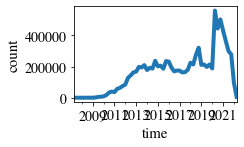

In [160]:
# data=tweet_df_en.reset_index().set_index('created_at').groupby(pd.Grouper(freq='3M')).text.count()
import math
data.plot(linewidth=4, figsize=get_fig_size())
plt.xticks(fontsize=tick_font)
plt.yticks(fontsize=tick_font)
plt.xlabel('time', fontsize=lbl_font)
plt.ylabel('count', fontsize=lbl_font)

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)
ax.grid(which='major', linestyle='-', linewidth='2', color='white')
ax.grid(axis='x')
ax.tick_params(axis='y', which='both', length=0)

background=".9"
ax.set_facecolor(background)
plt.setp(ax.spines.values(), color=background)
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=background)
plt.tight_layout()

plt.show()

### Sec/Priv tweets

In [22]:
priv_df = pd.read_pickle(data_root+'tweets-priv-processed.pkl')

#### Perc. of tweets related to sec/priv across groups

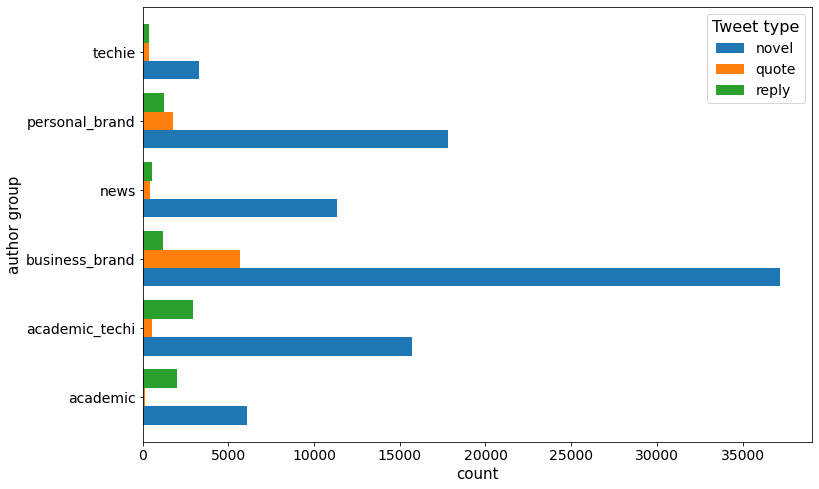

academic 8197 1.1325155052522358
academic_techi 19170 1.0698428218401965
business_brand 44097 4.647243870437408
news 12314 5.780732144701386
personal_brand 20846 1.822064231129276
techie 4042 2.861410600386524


author_group    tweet_type
academic        novel          6078
                quote           119
                reply          2000
academic_techi  novel         15710
                quote           547
                reply          2913
business_brand  novel         37210
                quote          5697
                reply          1190
news            novel         11315
                quote           455
                reply           544
personal_brand  novel         17838
                quote          1788
                reply          1220
techie          novel          3288
                quote           381
                reply           373
Name: text, dtype: int64

In [34]:
#Number of EN tweets across author groups
en_tweet_count = {'academic': 723787, 'academic_techi': 1791852, 'business_brand':948885, 'news':213018, 'personal_brand':1144087, 'techie':141259}

priv_df[priv_df.author_group!='unknown'].groupby(['author_group', 'tweet_type']).text.count().unstack().plot(kind='barh', width=.8, figsize=(12,8))
plt.yticks(fontsize=tick_font)
plt.xticks(fontsize=tick_font)
plt.xlabel('count', fontsize=lbl_font)
plt.ylabel('author group', fontsize=lbl_font)
plt.legend(title="Tweet type", title_fontsize=leg_font, fontsize=leg_font-2, fancybox=True)
plt.show()

for g in en_tweet_count.keys():
    c=priv_df[priv_df.author_group==g].text.count()
    print(g,c,c*100/en_tweet_count[g])

priv_df[priv_df.author_group!='unknown'].groupby(['author_group', 'tweet_type']).text.count()

In [20]:
priv_df.columns

Index(['author_id', 'text', 'created_at', 'geo', 'retweets', 'replies',
       'likes', 'quote_count', 'lang', 'conversation_id',
       'context_annotations', 'entities', 'attachments', 'possibly_sensitive',
       'withheld', 'reply_settings', 'source', 'search_term', 'senti', 'topic',
       'text_clean_topic', 'text_clean_senti', 'topic_cos', 'topic_con',
       'author_group'],
      dtype='object')

## Labeled tweets

In [58]:
labled_df = pd.read_pickle('all-sec-priv-labeled-tweets.pkl')

### Trend of labeled tweets

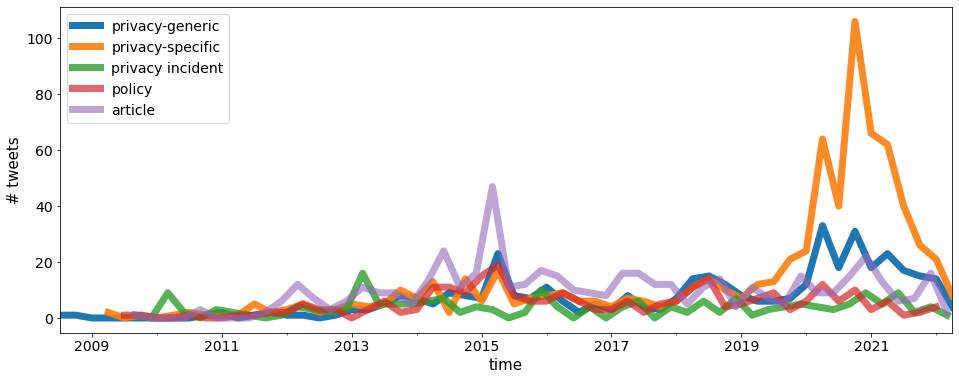

In [74]:
alpha=1
for code in ['privacy-generic', 'privacy-specific', 'privacy incident', 'policy'#, 'other-student-privacy', 'other-privacy'
             , 'article']:
    labled_df[labled_df.code==code].reset_index().set_index('created_at').groupby(pd.Grouper(freq='3M')).text.count().plot(
                    label=code, linewidth=7, figsize=(16,6), alpha=alpha)
    alpha=alpha-.1

plt.yticks(fontsize=tick_font)
plt.xticks(fontsize=tick_font)
plt.xlabel('time', fontsize=lbl_font)
plt.ylabel('# tweets', fontsize=lbl_font)
plt.legend(title="", title_fontsize=leg_font, fontsize=leg_font-2, fancybox=True)
plt.show()

### Groupwise analyses

In [60]:
print(labled_df[(labled_df.author_group!='unknown') &((labled_df.code=='privacy-generic') | (labled_df.code=='privacy-specific'))].groupby(['code', 'author_group']).text.count().to_frame().to_latex())

\begin{tabular}{llr}
\toprule
                 &        &  text \\
code & author\_group &       \\
\midrule
privacy-generic & academic &    33 \\
                 & academic\_techie &    86 \\
                 & business\_brand &    29 \\
                 & news &     7 \\
                 & personal &     6 \\
                 & personal\_brand &    25 \\
                 & techie &     1 \\
privacy-specific & academic &    80 \\
                 & academic\_techie &   125 \\
                 & business\_brand &    44 \\
                 & news &    16 \\
                 & personal &    13 \\
                 & personal\_brand &    34 \\
                 & techie &    21 \\
\bottomrule
\end{tabular}



/var/folders/1p/0rwj4hf522b5v3bzw33bsdqw0000gn/T/ipykernel_70296/3510451890.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(labled_df[(labled_df.author_group!='unknown') &((labled_df.code=='privacy-generic') | (labled_df.code=='privacy-specific'))].groupby(['code', 'author_group']).text.count().to_frame().to_latex())


#### Important words

In [62]:
corpus=list(labled_df[(labled_df.code=='privacy-generic')].text_clean_topic.values)
top_words = (get_tfidf_top_features(corpus, n_top=25))
np.array(top_words)

/Users/admin/work/edtech-scrape/edenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['datum', 'surveillance', 'school', 'eddata', 'issue', 'app',
       'concern', 'teacher', 'kid', 'security', 'protect', 'education',
       'parent', 'bad', 'child', 'information', 'online', 'company',
       'tool', 'violate', 'policy', 'lack', 'time', 'software', 'law'],
      dtype='<U15')

In [63]:
corpus=list(labled_df[(labled_df.code=='privacy-specific')].text_clean_topic.values)
top_words = (get_tfidf_top_features(corpus, n_top=25))
np.array(top_words)

array(['surveillance', 'school', 'edtech', 'issue', 'security', 'datum',
       'invasion', 'software', 'app', 'violation', 'google', 'concern',
       'policy', 'zoom', 'exam', 'kid', 'teacher', 'bad', 'violate',
       'online', 'proctorio', 'company', 'feel', 'email', 'facebook'],
      dtype='<U14')

###  Qualitative data

## Qualitative data

In [55]:
def get_tfidf_top_features(documents,n_top=10, max_df=.3, min_df=5):
    tfidf_vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df,stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(documents)
    importance = np.argsort(np.asarray(tfidf.sum(axis=0)).ravel())[::-1]
    tfidf_feature_names = np.array(tfidf_vectorizer.get_feature_names())
    return tfidf_feature_names[importance[:n_top]]


In [57]:
for t in ['privacy-generic', 'privacy-specific']:
    for a in ['academic', 'academic_techie', 'business_brand', 'personal_brand', 'personal','news','techie']:
        text = labled_df[(labled_df.author_group==a) & (labled_df.code==t)].text_clean_topic.values
        if len(text) > 1:
            tfidf = get_tfidf_top_features(text, n_top=11, max_df=.8, min_df=1)
            print('{}:  {}'.format(t+','+a, ', '.join(tfidf)))
    print()

privacy-generic,academic:  username, privacy, student, edtech, surveillance, datum, law, time, platform, issue, security
privacy-generic,academic_techie:  username, privacy, student, edtech, datum, school, surveillance, issue, app, teacher, kid
privacy-generic,business_brand:  privacy, username, student, datum, school, edtech, byod, surveillance, onlinesafety, security, fear
privacy-generic,personal_brand:  privacy, username, student, datum, edtech, eddata, teacher, concern, school, issue, sxswedu
privacy-generic,personal:  username, student, expectation, accountability, understand, secure, threaten, pjnet, keepyourpromise, intrusive, stopcommoncore
privacy-generic,news:  student, mooc, loss, major, drawback, blow, surveillance, username, people, rep, appropriately

privacy-specific,academic:  username, student, privacy, issue, datum, surveillance, concern, school, violation, teacher, tool
privacy-specific,academic_techie:  username, privacy, student, edtech, school, issue, security, g

In [61]:
# labled_df[(labled_df.code=='privacy-specific')&(labled_df.author_group=='personal')].text#.sample(5).text#.to_frame()

#### Visibility

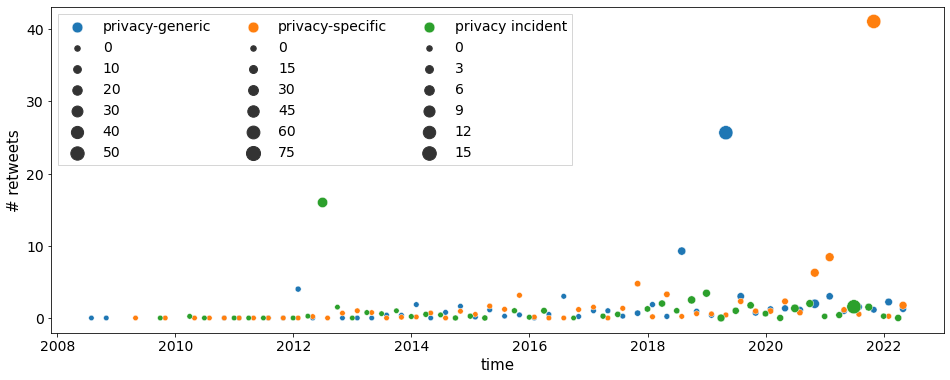

In [101]:
'''Retweets and likes on tweets expressing generic and specific concerns'''
import seaborn as sns
plt.figure(figsize=(16, 6))
# markers={'privacy-generic':'D', 'privacy-specific': 'o', 'privacy incident':'*'}
# g=labled_df[labled_df.code==code].reset_index().set_index('created_at').groupby(pd.Grouper(freq='6M'))
codes = ['privacy-generic', 'privacy-specific', 'privacy incident']#, 'article', 'policy']
for code in codes:
    g = labled_df[labled_df.code==code].reset_index().set_index('created_at').groupby(pd.Grouper(freq='3M'))#.text.count().plot(label=code, marker="o", markersize=15, linestyle='none')

    gdf = g.text.agg(['count'])
    gdf['retweets'] = g.retweets.mean()
    gdf['likes'] = g.likes.mean()
    gdf.reset_index(inplace=True)
    sns.scatterplot(
        data=gdf, x='created_at', y='retweets',  size="likes", label=code, marker='o',#markers[code],
        sizes=(30, 200)#, hue_norm=(0, 7)#, legend="full"
    )

plt.yticks(fontsize=tick_font)
plt.xticks(fontsize=tick_font)
plt.xlabel('time', fontsize=lbl_font)
plt.ylabel('# retweets', fontsize=lbl_font)
plt.legend(title="", title_fontsize=leg_font, fontsize=leg_font-2, fancybox=False, ncol=len(codes))
plt.show()

In [110]:
labled_df[labled_df.code=='privacy-specific'].sample(5).text

tweetid
1483880416234852363                                              We all use zoom. So, you might like this one. \nTwo new vulnerabilities have been reported to Zoom, a buffer overflow, and an information leak.\n\n#zoom #patch #vulnerability #bugs #cybersecurity #encryption #ASLR #appsec #seifhateb https://t.co/y6LvS7Wj2V
1364628940074020864    Companies like Honorlock are allowed to store the information you provide before an exam (biometrics, drivers license, 360 view of your personal surroundings, IP address, etc.) for over a year sometimes. Proctoring is a major violation of a student’s privacy. Get rid of it. https://t.co/vdRpGsaBbQ
1379500751118987266                                                                                              Super disappointed that @PPSConnect rolled out this Securly student surveillance software that tracks not only district loaner devices but all student authenticated browser activity with NO CHANCE TO OPT OUT.
554985602999779329        

In [117]:
labled_df[labled_df.apply(lambda row: 'inbloom' in row.text_clean_topic.lower(), axis=1)].groupby('code').text.count()#[['text_clean_topic']]

code
article                  4
other-privacy            1
other-student-privacy    4
policy                   2
privacy incident         5
privacy-generic          2
privacy-specific         6
tech_brandi              1
Name: text, dtype: int64

## Reddit data


In [118]:
labeled_df=pd.read_excel('priv-reddit-posts-labeled.xlsx')

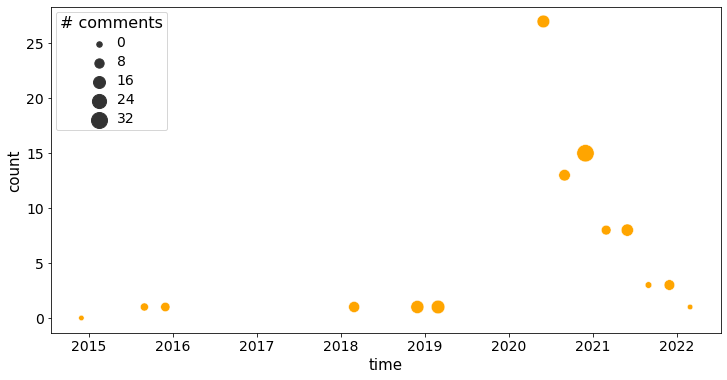

In [134]:
import seaborn as sns

plt.figure(figsize=(12,6))
g = labeled_df.reset_index().set_index('created_utc').groupby(pd.Grouper(freq='3M'))#.count()#.plot()
gdf = g.selftext.agg(['count'])
gdf['num_comments'] = g.num_comments.mean()
gdf.reset_index(inplace=True)
ax = sns.scatterplot(
        data=gdf, x='created_utc', y='count',  size="num_comments", marker='o', color='orange',#markers[code],
        sizes=(30, 300), hue_norm=(0, 7)#, legend="full"
    )

plt.yticks(fontsize=tick_font)
plt.xticks(fontsize=tick_font)
plt.xlabel('time', fontsize=lbl_font)
plt.ylabel('count', fontsize=lbl_font)

sns.move_legend(ax, "upper left", title="# comments")
plt.setp(ax.get_legend().get_texts(), fontsize=str(leg_font-2)) # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=str(leg_font)) # for legend title

#, bbox_to_anchor=(.55, .45), title='Species')
# plt.legend(title_fontsize=leg_font, fontsize=leg_font-2, fancybox=False, ncol=1)
plt.show()